# Ejemplo para el cálculo de costes de construccion en el alcance de estudios soluciones clase I (Estrategia protectora avance en paralelo): Parte 3 - Verificación del proceso constructivo mediante simulación numérica.

Este ejemplo continuará a partir de los datos temporales guardados al final del apartado [Parte 2 - Lectura de los datos de entrada asociados a la descripción del proceso constructivo](co_costes_construccion_02_es_c1.ipynb)

## Importación de paquetes de IPython

In [1]:
# hidden
import environment as env
env.initialize()

In [2]:
# Python 2/3 setup 
from __future__ import (absolute_import, division, print_function, unicode_literals)
# from builtins import *

In [3]:
# Juypyter setup

%matplotlib inline
import os
import sys
import pickle
import ast
import math
import pandas as pd
env.pandas_setup()
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

## Carga de variables del apartado anterior

In [4]:
# Getting back the objects:
dir_data = os.path.join(env.data_path, 'construccion', 'estudio_soluciones_clase1', 'var_co_costes_construccion_01_es_c1.pkl')

with open(dir_data) as f:  # Python 3: open(..., 'rb')
    n_tramos, de_planta, hora_acumulada, hora_inicio_tramos, p_invernal, alcance, estrategia, ruta_de, ruta_ds, rep_inmediata = pickle.load(f)

# Getting back the objects:
dir_data = os.path.join(env.data_path, 'construccion', 'estudio_soluciones_clase1', 'var_co_costes_construccion_02_es_c1.pkl')

with open(dir_data) as f:  # Python 3: open(..., 'rb')
    n, de_tramo, plan_avance, clima, com_fin_teorico, maquinaria_fases, eq_danno_fases, eq_coste_fases, costes_fase, restricciones_fases = pickle.load(f)

## Importación de paquetes para el ejemplo

In [5]:
import numpy as np

from construccion.calculos import calcula_n_horas_proteger
from construccion.calculos import actualiza_longitudes_fase_siguiente
from construccion.calculos import recorte_matrices_resultantes
from construccion.calculos import genera_matriz_volumen
from construccion.calculos import genera_matriz_estado
from construccion.calculos import genera_matriz_contador_proteccion_horas_fijas
from construccion.calculos import actualiza_matrices_fases_finalizadas

from construccion.clasificacion_main_fase_I import clasificacion_main_fase_I

from construccion.fases_nivel_III import fase_parada_invernal

from construccion.comprobaciones import comprueba_fase_acabada
from construccion.comprobaciones import comprueba_fase_finalizada

from construccion.calculos import calculo_costes
from construccion.calculos import calculo_longitudes_volumenes_acumulados
from construccion.calculos import extraccion_resultados

from construccion.representacion_v2 import representacion_resultados_tiempo


import logging

## Inicialización de las variables necesarias para la verificación del proceso constructivo

In [6]:
    # Inicializacion del dataframe de longitudes
    columnas = ['l_avanzada', 'l_protegida', 'l_desprotegida']
    indices = range(plan_avance.shape[0])
    longitudes = pd.DataFrame(0, index=indices, columns=columnas)

    # Inicializacion del dataframe de volumen ejecutado
    vol_ejecutado = genera_matriz_volumen(plan_avance)
    # Inicializacion del dataframe de volumen perdido a causa de los temporales
    vol_perdido = genera_matriz_volumen(plan_avance)
    # Inicializacion del dataframe de avance real (estado de la fase a Nivel 2)
    avance_real = genera_matriz_estado(plan_avance)
    # Inicializacion del dataframe de estado real (estado de la fase a Nivel 3)
    estado_real = genera_matriz_estado(plan_avance)
    # Inicializacion a 0 de los contadores de proteccion para las subfases que tengan horas de proteccion fijas
    cont_pro_h_fijas = genera_matriz_contador_proteccion_horas_fijas(plan_avance)

    # Inicializacion a 0 de los contadores de tiempo de arranque, hora, hora laborable y dia laborable
    columnas = ['t_arranque']
    cont_t_arranque = pd.DataFrame(0, index=indices, columns=columnas)
    hora = 0
    hora_labor = 0
    dia_labor = 0

    # Inicializacion a False del datafrae de las sub fases constructivas finalizadas (acabdas + protegidas)
    fases_finalizadas = pd.Series(np.full(plan_avance.shape[0], False, dtype=np.bool))

    # Inicializacion de todas las subfases del tramo para la simulacion
    fase_pos = fases_finalizadas[fases_finalizadas == False]  # nopep8
    
    


## Inicialización del fichero de logging

In [7]:
direct = os.path.join(ruta_ds, 'debug_info.log')
logging.basicConfig(filename=direct, level=logging.INFO)

## Verificacion del proceso constructivo

De acuerdo con el Articulado de la ROM 1.1, la verificación de la fase de construcción del dique se realiza en cada uno de los estados de que componen la vida útil. Se debe verificar de forma simultánea el avance de cada una de las subfases encargadas de ejecutar los distintos tramos de la traza de la obra. El esquema seguido para la verificación se muestran en el  documento del Manual de la ROM 1.1. La verificación en este alcance se realiza una vez a partir de las series históricas de los agentes propagadas a cada uno de los tramo del dique.

In [8]:
    # Inicio del proceso constructivo. Simula hasta que todas las fases se encuentren finalizadas
    while not fases_finalizadas.all():
        logging.info('Hora: ' + str(hora) + 'hs: ' + str(clima.loc[hora, 'hs']) + 'vv: ' + str(clima.loc[hora, 'vv']) + 'eta: ' + str(clima.loc[hora, 'eta']) + 'calado: ' + str(clima.loc[hora, 'calado']))

        actualiza_matrices_fases_finalizadas(fases_finalizadas, estado_real, hora)

        # Para cada hora (varia con un contador) se recorren cada una de las subfases del tramo
        for fase, _ in fase_pos.iteritems():

            # Se comprueba si esta hora se encuentra dentro de una parada invernal
            if hora_acumulada in p_invernal:
                (vol_ejecutado, longitudes) = fase_parada_invernal(fase, hora, de_tramo, longitudes, estado_real,
                                                                   vol_ejecutado, cont_t_arranque, avance_real,
                                                                   eq_danno_fases)

            else:

                # Para cada subfase, antes de comenzar la verificacion, se actualiza la longitud protegida en base a la
                # longitud avanzada por la fase siguiente. Limitando que la longitud protegida nunca sea mayor que la
                # avanzada.
                longitudes = actualiza_longitudes_fase_siguiente(fase, longitudes, plan_avance, de_tramo)

                # Se calcula para cada iteracion el numero de horas necesario para proteger la longitud desprotegida
                # de la subfase. Este dato se utilizara para clasificar la fase en funcion de que haya o no presencia
                # de temporal en las siguientes 'n_horas_fase' horas
                n_horas_fase = int(math.ceil(calcula_n_horas_proteger(de_tramo, longitudes, fase)))

                # Se inicia la verificacion: Para cada subfase en cada hora se obtiene un valor del volumen ejecutado,
                # el volumen perdido, la actualizacion de las longitudes avanzadaas, protegidas y desprotegidas y
                # la actualizacion de las matrices de estado y avance real.
                (vol_ejecutado, vol_perdido, longitudes,
                 cont_pro_h_fijas) = clasificacion_main_fase_I(fase, hora, clima, de_tramo, avance_real,
                                                               vol_ejecutado, longitudes, plan_avance,
                                                               n_horas_fase, estado_real, hora_labor,
                                                               cont_t_arranque, hora_acumulada,
                                                               com_fin_teorico, eq_danno_fases, vol_perdido,
                                                               restricciones_fases, dia_labor, cont_pro_h_fijas)

                # Tras la finalizacion de la simulacion de la subfase para el estado de mar se añade +1 al contador
                # de proteccion de horas fijas en caso de que ya se haya iniciado la proteccion, esto es que contador
                # para la subfase este activado (valor igual a 1)
                if cont_pro_h_fijas.ix[fase, 'activado'] == 1:
                    cont_pro_h_fijas.ix[fase, 'cont'] += 1

                # Se comprueba si la subfase ha acabado (volumen ejecutado >= volumen total de la subfase)
                comprueba_fase_acabada(
                    vol_ejecutado, de_tramo, estado_real, fase, hora, cont_t_arranque)

                # Se comprueba si la fase esta finalizada (acabada mas protegida)
                fases_finalizadas = comprueba_fase_finalizada(
                    plan_avance, fases_finalizadas, vol_ejecutado, de_tramo, fase, hora, cont_t_arranque)

        # Finaliza la verificacion para todas las subfases se avanza a la hora siguiente
        hora += 1
        # Se avanza la hora laborable
        hora_labor += 1
        # Se avanza la hora acumulada
        hora_acumulada += 1

        # Reinicio el contador cuando la hora laborable llega a 25 y avanzo 1 el dia laborable
        if hora_labor == 25:
            logging.info('Hora: ' + str(hora) + ' Reinicio contador hora laborable')
            logging.info('Hora: ' + str(hora) + ' Avanzo el contador de dia laborable')
            dia_labor += 1
            hora_labor = 0
        # Reinicio el contador dias laborables cuando llega a 7
        if dia_labor == 7:
            logging.info('Dia: ' + str(dia_labor) + ' Reinicio contador dia laborable')
            dia_labor = 0

        # Se extran las fases aun no finalizadas (acabadas + protegidas) para repetir la verificacion en la siguiente
        # hora
        fase_pos = fases_finalizadas[fases_finalizadas == False]  # nopep8
        
        #delete "\r" to append instead of overwrite
        sys.stdout.write("\r" + '   ---   ' +  str('LA: F0 ' +  str(np.round(longitudes.ix[0, 'l_avanzada']))) + str(' F1 ' +  str(np.round(longitudes.ix[1, 'l_avanzada']))) + str(' F2 ' +  str(np.round(longitudes.ix[2, 'l_avanzada']))) + str(' F3 ' +  str(np.round(longitudes.ix[3, 'l_avanzada']))) + str(' F4 ' +  str(np.round(longitudes.ix[4, 'l_avanzada']))) + str(' F5 ' +  str(np.round(longitudes.ix[5, 'l_avanzada']))) + str(' F6 ' +  str(np.round(longitudes.ix[6, 'l_avanzada']))) + str(' F7 ' +  str(np.round(longitudes.ix[7, 'l_avanzada']))) + str(' F8 ' +  str(np.round(longitudes.ix[8, 'l_avanzada']))) + str(' F9 ' +  str(np.round(longitudes.ix[9, 'l_avanzada']))) + str(' F10 ' +  str(np.round(longitudes.ix[10, 'l_avanzada']))) + '  ---  ' + str('LP  F0 ' +  str(np.round(longitudes.ix[0, 'l_protegida']))) + str(' F1 ' +  str(np.round(longitudes.ix[1, 'l_protegida']))) + str(' F2 ' +  str(np.round(longitudes.ix[2, 'l_protegida']))) + str(' F3 ' +  str(np.round(longitudes.ix[3, 'l_protegida']))) + str(' F4 ' +  str(np.round(longitudes.ix[4, 'l_protegida']))) + str(' F5 ' +  str(np.round(longitudes.ix[5, 'l_protegida']))) + str(' F6 ' +  str(np.round(longitudes.ix[6, 'l_protegida']))) + str(' F7 ' +  str(np.round(longitudes.ix[7, 'l_protegida']))) + str(' F8 ' +  str(np.round(longitudes.ix[8, 'l_protegida']))) + str(' F9 ' +  str(np.round(longitudes.ix[9, 'l_protegida']))) + str(' F10 ' +  str(np.round(longitudes.ix[10, 'l_protegida']))) )
        sys.stdout.flush()

   ---   LA: F0 500.0 F1 500.0 F2 500.0 F3 503.0 F4 503.0 F5 500.0 F6 500.0 F7 500.0 F8 500.0 F9 501.0 F10 500.0  ---  LP  F0 500.0 F1 500.0 F2 0.0 F3 501.0 F4 501.0 F5 0.0 F6 0.0 F7 500.0 F8 0.0 F9 0.0 F10 0.0

## Adjudicación de costes del proceso constructivo

Tras la verificación del proceso constructivo, los descriptores de la obra obtenidos se utilizan como datos de entrada para la adjudicación de costes siguiendo el esquema descrito en el Manual.

In [9]:
# Adjudicacion de costes a la simulacion del proceso constructivo
(costes_ejecc_sf_unit, costes_directos_sf_unit, costes_ejecc_sf_total, costes_directos_sf_total,
    costes_sf_total) = calculo_costes(plan_avance, maquinaria_fases, estado_real, vol_perdido, eq_coste_fases,
                                      eq_danno_fases, clima, costes_fase, vol_ejecutado)

## Almacenamiento de los resultados de la verificación

In [10]:
# Finalizada la verificacion del tramo se annade la hora de finalizacion del tramo que es la misma que la de
# inicio del tramo siguiente
hora_inicio_tramos.append(hora_acumulada)

# Recorte de matrices resultantes
(clima, avance_real, estado_real, vol_ejecutado, vol_perdido) = recorte_matrices_resultantes(
    hora, clima, avance_real, estado_real, vol_ejecutado, vol_perdido)

# Inicializacion de las variables de salida
de_tramo_total = []
com_fin_teorico_total = []
avance_real_total = []
estado_real_total = []
vol_ejecutado_total = []
vol_perdido_total = []
avance_real_total = []
longitudes_total = []
costes_ejecc_sf_unit_total = []
costes_directos_sf_unit_total = []
costes_ejecc_sf_total_total = []
costes_directos_sf_total_total = []
costes_sf_total_total = []
    
# Almaceno los resultados
de_tramo_total.append(de_tramo)
com_fin_teorico_total.append(com_fin_teorico)
avance_real_total.append(avance_real)
estado_real_total.append(estado_real)
vol_ejecutado_total.append(vol_ejecutado)
vol_perdido_total.append(vol_perdido)
longitudes_total.append(longitudes)

# if alcance != 'EA':
costes_ejecc_sf_unit_total.append(costes_ejecc_sf_unit)
costes_directos_sf_unit_total.append(costes_directos_sf_unit)
costes_ejecc_sf_total_total.append(costes_ejecc_sf_total)
costes_directos_sf_total_total.append(costes_directos_sf_total)
costes_sf_total_total.append(costes_sf_total)

(lon_ejecutada_total, lon_acumulada_total, vol_acumulado_total,
 lon_diferencia_total) = calculo_longitudes_volumenes_acumulados(estado_real_total, vol_ejecutado_total,
                                                                 de_tramo_total)

500.285714286
500.25
500.004500004
502.666666667
502.666666667
500.266666667
500.366666667
500.366666667
500.0
500.772547129
500.0


## Extraccion de resultados

In [11]:
# Extraccion de las variables de tiempos, probabilidades, volumenes y costes
(df_duracion, df_horas, df_probabilidad, df_tiempos, df_volumen, df_costes_ejecucion, df_costes_directos,
 df_costes_totales) = extraccion_resultados(de_planta, n, estado_real_total, vol_acumulado_total,
 vol_ejecutado_total, de_tramo_total, hora_inicio_tramos, vol_perdido_total, costes_ejecc_sf_total_total,
 costes_directos_sf_total_total, costes_sf_total_total, com_fin_teorico_total, ruta_de, ruta_ds, alcance)


## Resultados de la verificación del proceso constructivo y adjudicación de costes

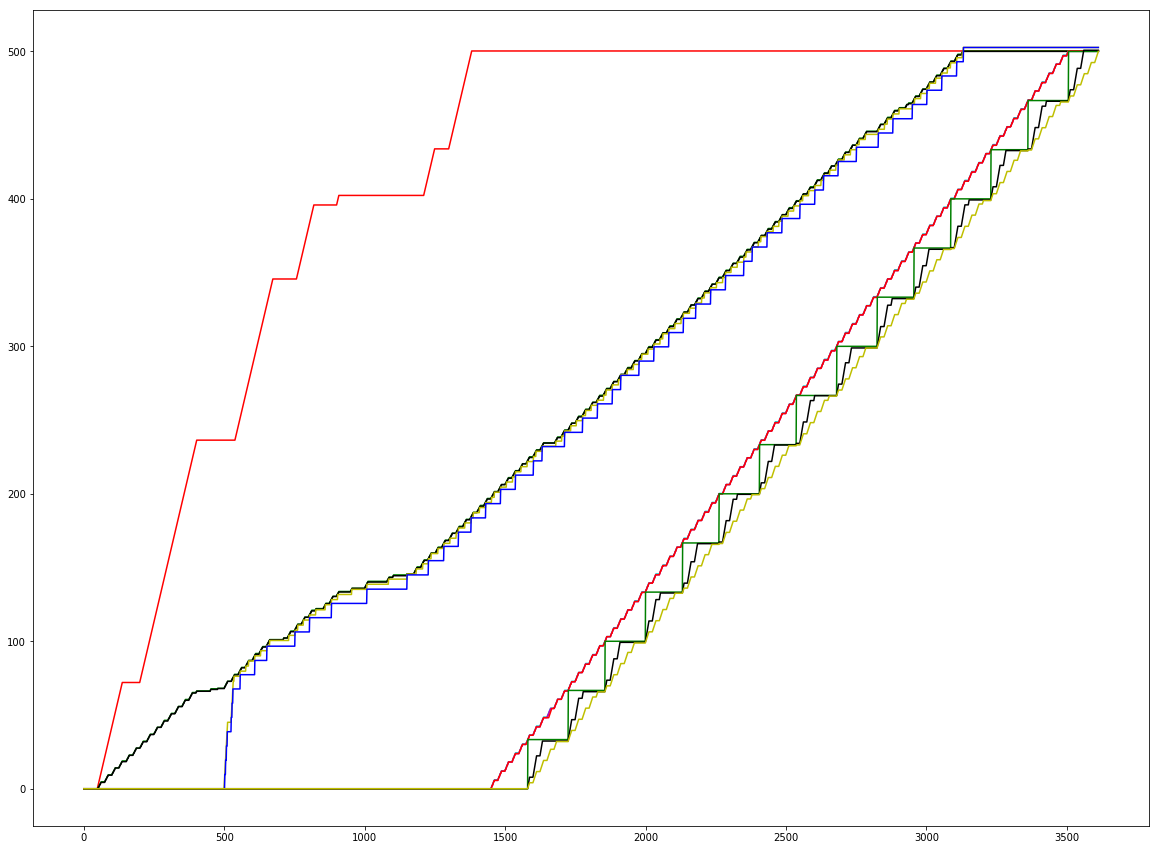

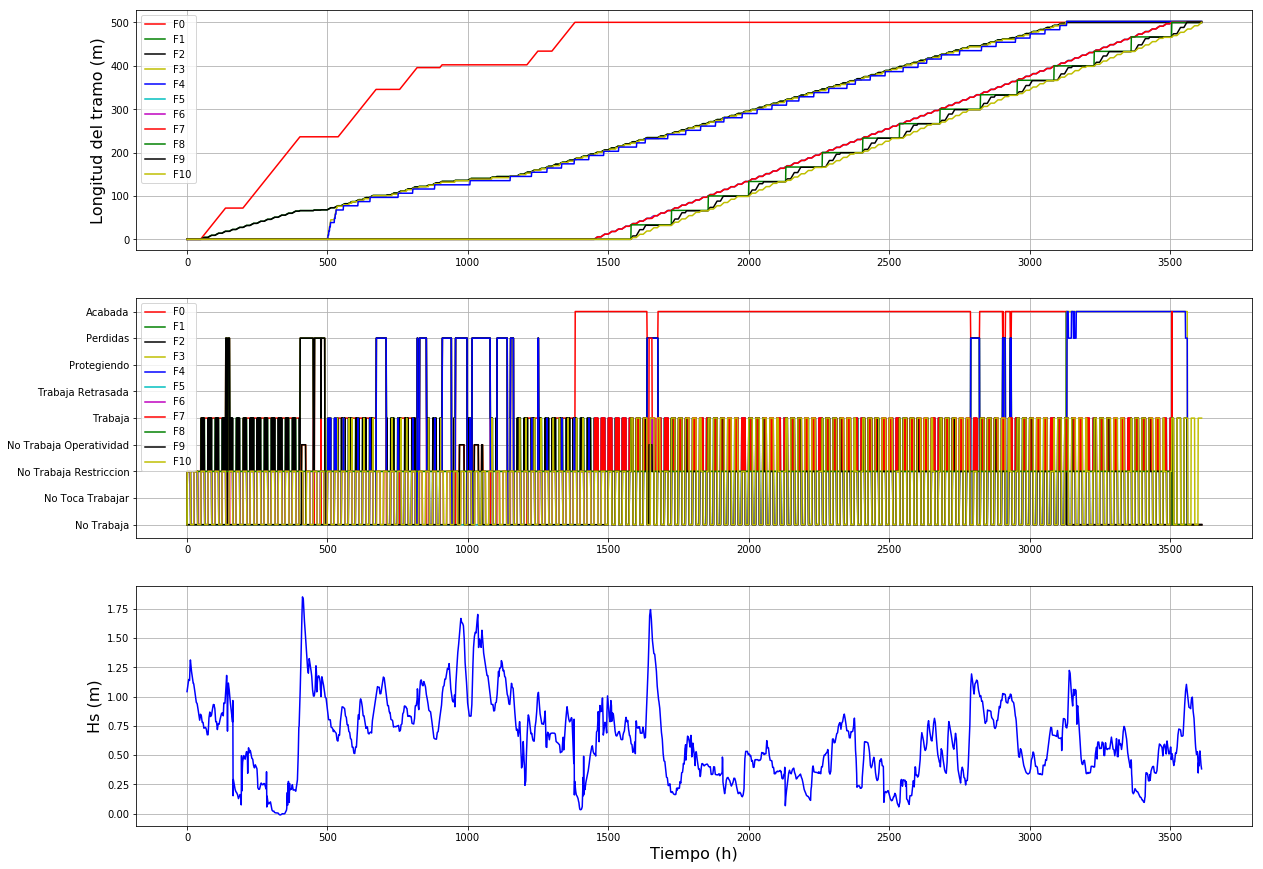

In [12]:
# Representacion de resultados de tiempo de ejecucion
representacion_resultados_tiempo(lon_acumulada_total, hora_inicio_tramos, estado_real_total, n, ruta_de, ruta_ds)

### Tiempos de ejecución

In [20]:
# Cambio el numero de filas y columnas que se muestran 
env.pandas_setup(50, 50)
df_tiempos

t_ejecucion_tramo  \
T_0 0_dragado                                       3613.0   
    1_vertido_nucleo_banqueta                       3613.0   
    2_vertido_manto_proteccion_banqueta             3613.0   
    3_enrase_banqueta_extraccion                    3613.0   
    4_enrase_banqueta_adicion                       3613.0   
    5_fabricacion_cajones                           3613.0   
    6_preparacion_cajones_remolque                  3613.0   
    7_transporte_cajones                            3613.0   
    8_acopio_cajones                                3613.0   
    9_fondeo_cajones                                3613.0   
    10_relleno_celda                                3613.0   

                                         t_ini_subfase_teorico  \
T_0 0_dragado                                              0.0   
    1_vertido_nucleo_banqueta                              0.0   
    2_vertido_manto_proteccion_banqueta                    0.0   
    3_enrase_banqueta_extraccion                           0.0   
    4_enrase_banqueta_adicion                              0.0   
    5_fabricacion_cajones                                  0.0   
    6_preparacion_cajones_remolque                         0.0   
    7_transporte_cajones                                   0.0   
    8_acopio_cajones                                       0.0   
    9_fondeo_cajones                                       0.0   
    10_relleno_celda                                       0.0   

                                         t_ini_subfase_real  \
T_0 0_dragado                                          48.0   
    1_vertido_nucleo_banqueta                          49.0   
    2_vertido_manto_proteccion_banqueta                50.0   
    3_enrase_banqueta_extraccion                      499.0   
    4_enrase_banqueta_adicion                         501.0   
    5_fabricacion_cajones                            1449.0   
    6_preparacion_cajones_remolque                   1450.0   
    7_transporte_cajones                             1450.0   
    8_acopio_cajones                                 1580.0   
    9_fondeo_cajones                                 1580.0   
    10_relleno_celda                                 1580.0   

                                         t_fin_subfase_teorico  \
T_0 0_dragado                                          99999.0   
    1_vertido_nucleo_banqueta                          99999.0   
    2_vertido_manto_proteccion_banqueta                99999.0   
    3_enrase_banqueta_extraccion                       99999.0   
    4_enrase_banqueta_adicion                          99999.0   
    5_fabricacion_cajones                              99999.0   
    6_preparacion_cajones_remolque                     99999.0   
    7_transporte_cajones                               99999.0   
    8_acopio_cajones                                   99999.0   
    9_fondeo_cajones                                   99999.0   
    10_relleno_celda                                   99999.0   

                                         t_fin_subfase_real  \
T_0 0_dragado                                        3130.0   
    1_vertido_nucleo_banqueta                        3130.0   
    2_vertido_manto_proteccion_banqueta              3130.0   
    3_enrase_banqueta_extraccion                     3560.0   
    4_enrase_banqueta_adicion                        3560.0   
    5_fabricacion_cajones                            3505.0   
    6_preparacion_cajones_remolque                   3506.0   
    7_transporte_cajones                             3506.0   
    8_acopio_cajones                                 3506.0   
    9_fondeo_cajones                                 3560.0   
    10_relleno_celda                                 3613.0   

                                         t_ejecucion_subfase  \
T_0 0_dragado                                         3082.0   
    1_vertido_nucleo_banqueta                         3081.0   
    

### Tiempos de parada

In [14]:
# Cambio el numero de filas y columnas que se muestran 
env.pandas_setup(50, 50)
df_tiempos

t_ejecucion_tramo  \
T_0 0_dragado                                       3613.0   
    1_vertido_nucleo_banqueta                       3613.0   
    2_vertido_manto_proteccion_banqueta             3613.0   
    3_enrase_banqueta_extraccion                    3613.0   
    4_enrase_banqueta_adicion                       3613.0   
    5_fabricacion_cajones                           3613.0   
    6_preparacion_cajones_remolque                  3613.0   
    7_transporte_cajones                            3613.0   
    8_acopio_cajones                                3613.0   
    9_fondeo_cajones                                3613.0   
    10_relleno_celda                                3613.0   

                                         t_ini_subfase_teorico  \
T_0 0_dragado                                              0.0   
    1_vertido_nucleo_banqueta                              0.0   
    2_vertido_manto_proteccion_banqueta                    0.0   
    3_enrase_banqueta_extraccion                           0.0   
    4_enrase_banqueta_adicion                              0.0   
    5_fabricacion_cajones                                  0.0   
    6_preparacion_cajones_remolque                         0.0   
    7_transporte_cajones                                   0.0   
    8_acopio_cajones                                       0.0   
    9_fondeo_cajones                                       0.0   
    10_relleno_celda                                       0.0   

                                         t_ini_subfase_real  \
T_0 0_dragado                                          48.0   
    1_vertido_nucleo_banqueta                          49.0   
    2_vertido_manto_proteccion_banqueta                50.0   
    3_enrase_banqueta_extraccion                      499.0   
    4_enrase_banqueta_adicion                         501.0   
    5_fabricacion_cajones                            1449.0   
    6_preparacion_cajones_remolque                   1450.0   
    7_transporte_cajones                             1450.0   
    8_acopio_cajones                                 1580.0   
    9_fondeo_cajones                                 1580.0   
    10_relleno_celda                                 1580.0   

                                         t_fin_subfase_teorico  \
T_0 0_dragado                                          99999.0   
    1_vertido_nucleo_banqueta                          99999.0   
    2_vertido_manto_proteccion_banqueta                99999.0   
    3_enrase_banqueta_extraccion                       99999.0   
    4_enrase_banqueta_adicion                          99999.0   
    5_fabricacion_cajones                              99999.0   
    6_preparacion_cajones_remolque                     99999.0   
    7_transporte_cajones                               99999.0   
    8_acopio_cajones                                   99999.0   
    9_fondeo_cajones                                   99999.0   
    10_relleno_celda                                   99999.0   

                                         t_fin_subfase_real  \
T_0 0_dragado                                        3130.0   
    1_vertido_nucleo_banqueta                        3130.0   
    2_vertido_manto_proteccion_banqueta              3130.0   
    3_enrase_banqueta_extraccion                     3560.0   
    4_enrase_banqueta_adicion                        3560.0   
    5_fabricacion_cajones                            3505.0   
    6_preparacion_cajones_remolque                   3506.0   
    7_transporte_cajones                             3506.0   
    8_acopio_cajones                                 3506.0   
    9_fondeo_cajones                                 3560.0   
    10_relleno_celda                                 3613.0   

                                         t_ejecucion_subfase  \
T_0 0_dragado                                         3082.0   
    1_vertido_nucleo_banqueta                         3081.0   
    

### Duración de las paradas

In [15]:
df_horas

n_horas_subfase_no_trabaja_por_restriccion  \
T_0 0_dragado                                                                   0.0   
    1_vertido_nucleo_banqueta                                                  25.0   
    2_vertido_manto_proteccion_banqueta                                       588.0   
    3_enrase_banqueta_extraccion                                             1193.0   
    4_enrase_banqueta_adicion                                                1401.0   
    5_fabricacion_cajones                                                       0.0   
    6_preparacion_cajones_remolque                                            943.0   
    7_transporte_cajones                                                     2561.0   
    8_acopio_cajones                                                         3491.0   
    9_fondeo_cajones                                                          622.0   
    10_relleno_celda                                                         1024.0   

                                         n_horas_subfase_no_trabaja_por_operatividad  \
T_0 0_dragado                                                                    0.0   
    1_vertido_nucleo_banqueta                                                    0.0   
    2_vertido_manto_proteccion_banqueta                                          0.0   
    3_enrase_banqueta_extraccion                                                62.0   
    4_enrase_banqueta_adicion                                                    0.0   
    5_fabricacion_cajones                                                        0.0   
    6_preparacion_cajones_remolque                                               0.0   
    7_transporte_cajones                                                        51.0   
    8_acopio_cajones                                                             0.0   
    9_fondeo_cajones                                                            62.0   
    10_relleno_celda                                                             0.0   

                                         n_horas_subfase_esta_protegiendo  \
T_0 0_dragado                                                         0.0   
    1_vertido_nucleo_banqueta                                         0.0   
    2_vertido_manto_proteccion_banqueta                               0.0   
    3_enrase_banqueta_extraccion                                      0.0   
    4_enrase_banqueta_adicion                                         0.0   
    5_fabricacion_cajones                                             0.0   
    6_preparacion_cajones_remolque                                    0.0   
    7_transporte_cajones                                              0.0   
    8_acopio_cajones                                                  0.0   
    9_fondeo_cajones                                                  0.0   
    10_relleno_celda                                                  0.0   

                                         n_horas_subfase_esta_en_perdidas  
T_0 0_dragado                                                       431.0  
    1_vertido_nucleo_banqueta                                       431.0  
    2_vertido_manto_proteccion_banqueta                             431.0  
    3_enrase_banqueta_extraccion                                      0.0  
    4_enrase_banqueta_adicion                                       363.0  
    5_fabricacion_cajones                                             0.0  
    6_preparacion_cajones_remolque                                    0.0  
    7_transporte_cajones                                             11.0  
    8_acopio_cajones                                                  0.0  
    9_fondeo_cajones                                                  0.0  
    10_relleno_celda                                                  0.0

### Volumen de pérdidas

In [16]:
df_volumen

volumen_ejecutado_teorico  \
T_0 0_dragado                                             189000.0   
    1_vertido_nucleo_banqueta                             200000.0   
    2_vertido_manto_proteccion_banqueta                   111111.0   
    3_enrase_banqueta_extraccion                           15000.0   
    4_enrase_banqueta_adicion                               7500.0   
    5_fabricacion_cajones                                     15.0   
    6_preparacion_cajones_remolque                            15.0   
    7_transporte_cajones                                      15.0   
    8_acopio_cajones                                          15.0   
    9_fondeo_cajones                                          15.0   
    10_relleno_celda                                      172000.0   

                                         volumen_ejecutado_real  \
T_0 0_dragado                                     189108.000000   
    1_vertido_nucleo_banqueta                     200100.000000   
    2_vertido_manto_proteccion_banqueta           111112.000000   
    3_enrase_banqueta_extraccion                   15080.000000   
    4_enrase_banqueta_adicion                       7540.000000   
    5_fabricacion_cajones                             15.008000   
    6_preparacion_cajones_remolque                    15.011000   
    7_transporte_cajones                              15.011000   
    8_acopio_cajones                                  15.000000   
    9_fondeo_cajones                                  15.023176   
    10_relleno_celda                              172000.000000   

                                         volumen_minimo_perdidas_material  \
T_0 0_dragado                                                 -148.234091   
    1_vertido_nucleo_banqueta                                   -0.056721   
    2_vertido_manto_proteccion_banqueta                       -617.564254   
    3_enrase_banqueta_extraccion                                 0.000000   
    4_enrase_banqueta_adicion                                  -12.923093   
    5_fabricacion_cajones                                        0.000000   
    6_preparacion_cajones_remolque                               0.000000   
    7_transporte_cajones                                        -4.895000   
    8_acopio_cajones                                             0.000000   
    9_fondeo_cajones                                             0.000000   
    10_relleno_celda                                             0.000000   

                                         volumen_maximo_perdidas_material  \
T_0 0_dragado                                              -808316.027273   
    1_vertido_nucleo_banqueta                                -1640.422708   
    2_vertido_manto_proteccion_banqueta                    -260705.435978   
    3_enrase_banqueta_extraccion                                 0.000000   
    4_enrase_banqueta_adicion                               -16588.585859   
    5_fabricacion_cajones                                        0.000000   
    6_preparacion_cajones_remolque                               0.000000   
    7_transporte_cajones                                        -4.895000   
    8_acopio_cajones                                             0.000000   
    9_fondeo_cajones                                             0.000000   
    10_relleno_celda                                             0.000000   

                                         volumen_medio_perdidas_material  \
T_0 0_dragado                                             -158446.238038   
    1_vertido_nucleo_banqueta                                -215.468903   
    2_vertido_manto_proteccion_banqueta                    -57887.872893   
    3_enrase_banqueta_extraccion                                0.000000   
    4_enrase_banqueta_adicion                               -3180.191660   
    5_fabricacion_cajones                                       0.000000   
    6_prepara

### Probabilidad de fallo y parada operativa

In [17]:
df_probabilidad

probabilidad_de_fallo  \
T_0 0_dragado                                         0.139844   
    1_vertido_nucleo_banqueta                         0.139890   
    2_vertido_manto_proteccion_banqueta               0.139935   
    3_enrase_banqueta_extraccion                      0.000000   
    4_enrase_banqueta_adicion                         0.118666   
    5_fabricacion_cajones                             0.000000   
    6_preparacion_cajones_remolque                    0.000000   
    7_transporte_cajones                              0.005350   
    8_acopio_cajones                                  0.000000   
    9_fondeo_cajones                                  0.000000   
    10_relleno_celda                                  0.000000   

                                         probabilidad_parada_operativa  
T_0 0_dragado                                                 0.000000  
    1_vertido_nucleo_banqueta                                 0.000000  
    2_vertido_manto_proteccion_banqueta                       0.000000  
    3_enrase_banqueta_extraccion                              0.020255  
    4_enrase_banqueta_adicion                                 0.000000  
    5_fabricacion_cajones                                     0.000000  
    6_preparacion_cajones_remolque                            0.000000  
    7_transporte_cajones                                      0.024805  
    8_acopio_cajones                                          0.000000  
    9_fondeo_cajones                                          0.031313  
    10_relleno_celda                                          0.000000

In [18]:
df_costes_totales

c_directos_total  c_indirectos_total  \
T_0 0_dragado                                8.652000e+05        86520.000000   
    1_vertido_nucleo_banqueta                3.167100e+06       316710.000000   
    2_vertido_manto_proteccion_banqueta      1.346416e+06       134641.600000   
    3_enrase_banqueta_extraccion             1.450000e+05        14500.000000   
    4_enrase_banqueta_adicion                1.086800e+05        10868.000000   
    5_fabricacion_cajones                    5.853120e+04         5853.120000   
    6_preparacion_cajones_remolque           5.854290e+04         5854.290000   
    7_transporte_cajones                     6.030890e+04         6030.890000   
    8_acopio_cajones                         0.000000e+00            0.000000   
    9_fondeo_cajones                         5.859039e+04         5859.038801   
    10_relleno_celda                         1.255600e+06       125560.000000   

                                         c_perdidas_total       c_total  
T_0 0_dragado                                1.823808e+07  1.918980e+07  
    1_vertido_nucleo_banqueta                8.187818e+04  3.565688e+06  
    2_vertido_manto_proteccion_banqueta      2.675358e+07  2.823464e+07  
    3_enrase_banqueta_extraccion             0.000000e+00  1.595000e+05  
    4_enrase_banqueta_adicion                2.595049e+06  2.714597e+06  
    5_fabricacion_cajones                    0.000000e+00  6.438432e+04  
    6_preparacion_cajones_remolque           0.000000e+00  6.439719e+04  
    7_transporte_cajones                     1.909050e+04  8.543029e+04  
    8_acopio_cajones                         0.000000e+00  0.000000e+00  
    9_fondeo_cajones                         0.000000e+00  6.444943e+04  
    10_relleno_celda                         0.000000e+00  1.381160e+06